In [102]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

In [103]:
def cubic_bezier(p, ts):
    return (1-ts)**3*p[0] + 3*(1-ts)**2*ts*p[1]+3*(1-ts)*ts**2*p[2]+ts**3*p[3]

In [104]:
def cubic_bezier_arc_3D(px, py, pz, unit_arc=0.1):
    t = 0
    ts = torch.tensor([0]).to(cfg.device)
    while t <= 1:
        dx = 3*(1 - t)**2 * (px[1] - px[0]) + 6 * (1-t) * t * (px[2] - px[1]) + 3*t**2*(px[3] - px[2])
        dy = 3*(1 - t)**2 * (py[1] - py[0]) + 6 * (1-t) * t * (py[2] - py[1]) + 3*t**2*(py[3] - py[2])
        dz = 3*(1 - t)**2 * (pz[1] - pz[0]) + 6 * (1-t) * t * (pz[2] - pz[1]) + 3*t**2*(pz[3] - pz[2])

        dt = unit_arc / torch.sqrt(dx**2 + dy**2 + dz**2)

        t = t + dt

        ts = torch.hstack((ts, t))
    ts = ts[:-1]
    xs = cubic_bezier(px, ts)
    ys = cubic_bezier(py, ts)
    zs = cubic_bezier(pz, ts)

    return torch.vstack((xs, ys, zs))

In [105]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    # V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(1e5*(V_boundary_stiffness_threshold - 1e-2))


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [106]:
control_point = 31

In [107]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)
mesh_origin = mesh.copy()

torch.Size([600, 3])
torch.Size([1200, 3])


In [108]:
spline_control = np.array([[0.000224, 0.010794, -0.001233],
                           [-0.0017,  0.0025,  0.0006],
                           [-0.0015, -0.0016,  0.0038],
                           [-0.0002, -0.0047,  0.0078]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [109]:
spline_line = cubic_bezier_arc_3D(spline_control[:, 0], spline_control[:, 1], spline_control[:, 2], 0.00025)

In [110]:
spline_line.shape

torch.Size([3, 75])

In [111]:
pv.set_plot_theme('document')
pl = pv.Plotter()
# skin being peeled
actor1 =  pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# control line
pl.add_lines(spline_line.cpu().numpy().T, color='r', connected=True)
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7f256943c280)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7f25694ee740)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [112]:
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness
energy_list = []
tense_boundary_list = []
pl.open_gif('peeling1.gif')
boundary_energy_matrix = torch.zeros(75, 600).to(cfg.device)
spline_line = torch.transpose(spline_line, 0, 1)
for i in range(spline_line.shape[0]):
    softbody.V[control_point] = spline_line[i]
    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    ref_V_boundary_stiffness = V_boundary_stiffness[:cfg.n_surf].detach().clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    boundary_energy_matrix[i] = energy.squeeze()
    tense_idx = energy.squeeze() > 1e-9
    tense_boundary_list.append(torch.sum(tense_idx).detach().cpu().numpy())
    
    # set boundary energy that larger than 1e-8 as broken, 1e-5 is a eps to avoid divide 0
    V_boundary_stiffness[:cfg.n_surf] = ref_V_boundary_stiffness * torch.sigmoid(1e10 * (1e-8 - energy)) + 1e-5*torch.sigmoid(1e10 * (energy - 1e-8))
    # V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
    mesh.points = softbody.V.detach().cpu().numpy()[:cfg.n_surf]
    energy_list.append(energy.detach().cpu().numpy().reshape(cfg.n_surf))
    pl.remove_actor(actor1)
    pl.add_mesh(mesh, scalars=energy.squeeze().cpu(), show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', cmap='jet')
    # pl.update()
    # pl.show()
    pl.write_frame()
pl.close()

In [113]:
energy_list = np.array(energy_list)
energy_per_iter = np.sum(energy_list, axis=1)
tense_boundary_list = np.array(tense_boundary_list)

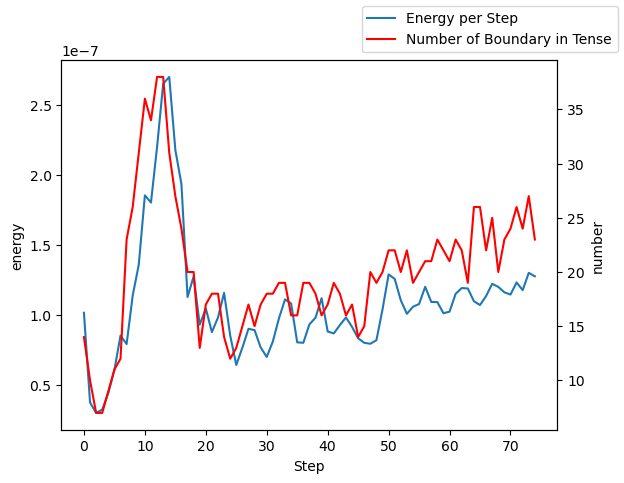

In [114]:
fig, ax1 = plt.subplots()
ax1.plot(energy_per_iter, label='Energy per Step')
ax1.set_xlabel('Step')
ax1.set_ylabel('energy')

ax2 = ax1.twinx()
ax2.plot(tense_boundary_list, color='r', label='Number of Boundary in Tense')
ax2.set_ylabel('number')


fig.legend(loc='upper right')


In [115]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)
mesh_origin = mesh.copy()

torch.Size([600, 3])
torch.Size([1200, 3])


In [116]:
spline_control = np.array([[0.0002, 0.0011, 0.0010, 0.0059],
                           [0.0108, 0.0117, 0.0113, 0.0141],
                           [-0.0012,  0.0003,  0.0007,  0.0076]])
spline_control = torch.from_numpy(spline_control.T).to(cfg.device)

In [117]:
spline_line = cubic_bezier_arc_3D(spline_control[:, 0], spline_control[:, 1], spline_control[:, 2], 0.00025)

In [118]:
pv.set_plot_theme('document')
pl = pv.Plotter()
# skin being peeled
actor1 =  pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# control line
# control line
pl.add_lines(spline_line.cpu().numpy().T, color='r', connected=True)
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7f2569830940)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7f256935c2e0)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [119]:
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness
energy_list2 = []
tense_boundary_list2 = []
pl.open_gif('peeling2.gif')
boundary_energy_matrix = torch.zeros(75, 600).to(cfg.device)
spline_line = torch.transpose(spline_line, 0, 1)
for i in range(spline_line.shape[0]):
    softbody.V[control_point] = spline_line[i]
    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    ref_V_boundary_stiffness = V_boundary_stiffness[:cfg.n_surf].detach().clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    boundary_energy_matrix[i] = energy.squeeze()
    tense_idx = energy.squeeze() > 1e-9
    tense_boundary_list2.append(torch.sum(tense_idx).detach().cpu().numpy())
    
    # set boundary energy that larger than 1e-8 as broken, 1e-5 is a eps to avoid divide 0
    V_boundary_stiffness[:cfg.n_surf] = ref_V_boundary_stiffness * torch.sigmoid(1e10 * (1e-8 - energy)) + 1e-5*torch.sigmoid(1e10 * (energy - 1e-8))
    # V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
    mesh.points = softbody.V.detach().cpu().numpy()[:cfg.n_surf]
    energy_list2.append(energy.detach().cpu().numpy().reshape(cfg.n_surf))
    pl.remove_actor(actor1)
    pl.add_mesh(mesh, scalars=energy.squeeze().cpu(), show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', cmap='jet')
    # pl.update()
    # pl.show()
    pl.write_frame()
pl.close()

In [120]:
energy_list2 = np.array(energy_list2)
energy_per_iter2 = np.sum(energy_list2, axis=1)
tense_boundary_list2 = np.array(tense_boundary_list2)

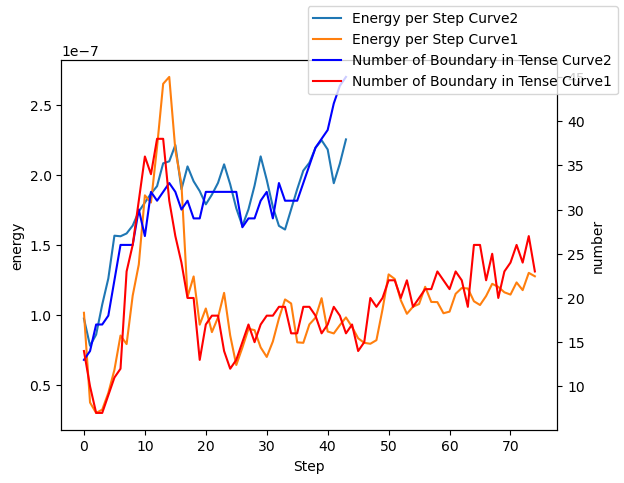

In [121]:
fig, ax1 = plt.subplots()
ax1.plot(energy_per_iter2, label='Energy per Step Curve2')
ax1.plot(energy_per_iter, label='Energy per Step Curve1')
ax1.set_xlabel('Step')
ax1.set_ylabel('energy')

ax2 = ax1.twinx()
ax2.plot(tense_boundary_list2, color='b', label='Number of Boundary in Tense Curve2')
ax2.plot(tense_boundary_list, color='r', label='Number of Boundary in Tense Curve1')
ax2.set_ylabel('number')


fig.legend(loc='upper right')
